# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
import warnings
warnings.filterwarnings('ignore')

# 1. Loading Libraries

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as ss
import prettytable
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_validate
import re # Go to https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#randomly sampling positive and negative datapoints and from the dataframe 'df' and creating new data frame total_points
#positive_points = df[df['Score'] == 'positive'].sample(n=50000, random_state=0)#randomly sampling 20k positive points
#negative_points = df[df['Score'] == 'negative'].sample(n=50000, random_state=0)# randomly sampling 20k negative points
#total_points = pd.concat([positive_points, negative_points])#concatenating the positive_points and negative_points dataframe

# Sorting based on time
#sorted_data = total_points.sort_values('Time', #Here we are sorting filtered_data according to Time in 
#                                        axis = 0,    #- ascending order so that we can do time based splitting later.
#                                     inplace = False, #inpace = false because we dont want to make modifications in-
                                      #- fitered data rather we want to keep filtered_data preserved and store the modified-
                                      #- data in sorted_data
#                                    kind = 'quicksort',
#                                     na_position = 'last')
#sorted_data['Score'].value_counts()
#sorted_data.to_csv('sorted_data_df.csv')
sorted_data = pd.read_csv('sorted_data_df.csv')

In [4]:
sorted_data.shape

(100000, 13)

In [5]:
d_train = sorted_data.iloc[0:60000] #taking top 60k data points from sorted_data and storing it in d_train
d_cv = sorted_data.iloc[60000:80000]#taking next 20k data points from sorted_data and storing it in d_cv
d_test = sorted_data.iloc[80000:100000]#taking last 20k data points from sorted_data and storing it in d_test

In [8]:
d_train_1 = sorted_data.iloc[0:5000] #taking top 5k data points from sorted_data and storing it in d_train
d_cv_1 = sorted_data.iloc[5000:7500]#taking next 2.5k data points from sorted_data and storing it in d_cv
d_test_1 = sorted_data.iloc[7500:10000]#taking last 2.5k data points from sorted_data and storing it in d_test

In [9]:
#Storing 'CleanedText' and 'Score' columns in d_train into x_train and y_train respectively and doing the same for d_cv,
#-d_test, d_train_1,d_cv_1 and d_test_1
x_train = d_train['CleanedText']
x_cv = d_cv['CleanedText']
x_test = d_test['CleanedText']
y_train = d_train['Score']
y_cv = d_cv['Score']
y_test = d_test['Score']

x_train_1 = d_train_1['CleanedText']
x_cv_1 = d_cv_1['CleanedText']
x_test_1 = d_test_1['CleanedText']
y_train_1 = d_train_1['Score']
y_cv_1 = d_cv_1['Score']
y_test_1 = d_test_1['Score']

In [10]:
y_train.shape

(60000,)

In [11]:
#The below functio changes 'negative' to 0 and 'positive' to 1 in y_train, y_cv and y_test and thus binarizes the elements-
#- in y_train, y_cv and y_test such that now 1 will represent positive points and 0 will represent negative points
lb = preprocessing.LabelBinarizer()
list_1 = []
for i in y_train:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_train = a
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [12]:
y_train.shape

(60000, 1)

In [13]:
list_1 = []
for i in y_cv:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_cv = a
lb.fit(y_cv)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [14]:
list_1 = []
for i in y_test:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_test = a
lb.fit(y_test)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [15]:
lb = preprocessing.LabelBinarizer()
list_1 = []
for i in y_train_1:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_train_1 = a
lb.fit(y_train_1)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [16]:
list_1 = []
for i in y_cv_1:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_cv_1 = a
lb.fit(y_cv_1)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [17]:
list_1 = []
for i in y_test_1:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_test_1 = a
lb.fit(y_test_1)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [18]:
y_train= np.ravel(y_train)
y_cv= np.ravel(y_cv)
y_test= np.ravel(y_test)
y_train_1= np.ravel(y_train_1)
y_cv_1= np.ravel(y_cv_1)
y_test_1= np.ravel(y_test_1)

In [19]:
y_train.shape

(60000,)

# 2. Bag of words (BOW)

In [20]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer = CountVectorizer(min_df = 10) #defining our BOW model here. 
model = vectorizer.fit(x_train)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'unsaf': 6445, 'array': 287, 'instinct': 3120, 'slipperi': 5484, 'lesser': 3446, 'cancer': 864, 'gardenia': 2495, 'sauc': 5190, 'theyv': 6124, 'frother': 2444, 'roof': 5093, 'petsmart': 4454, 'phosphorus': 4469, 'tub': 6323, 'devast': 1665, 'purpos': 4771, 'happier': 2766, 'snag': 5526, 'pebbl': 4385, 'quencher': 4794, 'macaroon': 3592, 'unsavori': 6450, 'effort': 1957, 'zone': 6891, 'heavili': 2832, 'real': 4861, 'gasolin': 2502, 'gumbal': 2725, 'protein': 4723, 'mother': 3909, 'stat': 5739, 'multitud': 3943, 'feel': 2225, 'steer': 5754, 'clinic': 1149, 'chip': 1061, 'swheat': 5956, 'degre': 1598, 'leatheri': 3418, 'hurrican': 2973, 'someplac': 5577, 'indiana': 3060, 'excel': 2099, 'pamela': 4310, 'father': 2195, 'wholefood': 6725, 'sri': 5708, 'salami': 5159, 'puf': 4742, 'trident': 6300, 'china': 1058, 'tame': 6002, 'wrapper': 6806, 'strengthen': 5814, 'glorious': 2573, 'starkist': 5733, 'best': 534, 'process': 4690, 'decay': 1560, 'unusu': 6460, 'proceed': 4689, 'disturb': 1789, '

In [21]:
train_bow = model.transform(x_train)#converting the internal parameters(i.e vocab) into vectors
cv_bow = model.transform(x_cv)# using the same vocab of x_train I am transforming the text in x_cv into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_bow = model.transform(x_test)# using the same vocab of x_train I am transforming the text in x_test into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [22]:
#here we are creating a dataframe out of train_bow,cv_bow and test_bow
train_bow_df = pd.DataFrame(train_bow.toarray(),columns = model.get_feature_names())
cv_bow_df = pd.DataFrame(cv_bow.toarray(),columns = model.get_feature_names())
test_bow_df = pd.DataFrame(test_bow.toarray(),columns = model.get_feature_names())

In [23]:
#Here we are standardizing dataframes train_bow_df, cv_bow_df and test_bow_df
standardized_train = StandardScaler().fit_transform(train_bow_df)
standardized_cv = StandardScaler().fit_transform(cv_bow_df)
standardized_test = StandardScaler().fit_transform(test_bow_df)

In [24]:
standardized_train.shape

(60000, 6895)

### [2.1] Applying Linear SVM on BOW

In [25]:
#Here we are trying to find area under AUC score  for train dataset for various values of-
#- alpha and penalty using SGD Classifier
train_roc_l1 = []
train_roc_l2 = []
alpha = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
penality = ['l1','l2']
for i in penality:
    for j in alpha:
        lr_svm = SGDClassifier(penalty = i,alpha=j)
        lr_svm.fit(standardized_train,y_train)
        pred = lr_svm.predict(standardized_train)
        if i=='l1':
            train_roc_l1.append(roc_auc_score(y_train, pred))
        elif i=='l2':
            train_roc_l2.append(roc_auc_score(y_train, pred))

In [26]:
#performing simple cross validation using SGD Classifier for various values of alpha and penality. Our metrics are-
#- area under auc curve
cv_roc_l1 = []
cv_roc_l2 = []
alpha = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
penality = ['l1','l2']
for i in penality:
    for j in alpha:
        lr_svm = SGDClassifier(penalty = i,alpha=j)
        lr_svm.fit(standardized_train,y_train)
        pred = lr_svm.predict(standardized_cv)
        if i=='l1':
            cv_roc_l1.append(roc_auc_score(y_cv, pred))
        elif i=='l2':
            cv_roc_l2.append(roc_auc_score(y_cv, pred))
        print('\nFor alpha = {0} and penality = {1}, the area under AUC curve is = {2}'.format(j,i,roc_auc_score(y_cv, pred)))


For alpha = 10000 and penality = l1, the area under AUC curve is = 0.5

For alpha = 1000 and penality = l1, the area under AUC curve is = 0.5

For alpha = 100 and penality = l1, the area under AUC curve is = 0.5

For alpha = 10 and penality = l1, the area under AUC curve is = 0.5

For alpha = 1 and penality = l1, the area under AUC curve is = 0.5

For alpha = 0.1 and penality = l1, the area under AUC curve is = 0.5934541062801933

For alpha = 0.1 and penality = l1, the area under AUC curve is = 0.5176167471819645

For alpha = 0.01 and penality = l1, the area under AUC curve is = 0.7733655394524961

For alpha = 0.001 and penality = l1, the area under AUC curve is = 0.8059158615136877

For alpha = 0.0001 and penality = l1, the area under AUC curve is = 0.8309118357487923

For alpha = 10000 and penality = l2, the area under AUC curve is = 0.5

For alpha = 1000 and penality = l2, the area under AUC curve is = 0.5

For alpha = 100 and penality = l2, the area under AUC curve is = 0.5

For a

#### Observation:
<pre>From above we can see that we are getting maximum AUC for alpha = 0.1, penality = l2. Therefore now we will use these two values of hyperparameters on our test dataset.</pre>

In [27]:
#Taking log of C values
log_alpha = np.log(np.array(alpha))
log_alpha

array([ 9.21034037,  6.90775528,  4.60517019,  2.30258509,  0.        ,
       -2.30258509, -2.30258509, -4.60517019, -6.90775528, -9.21034037])

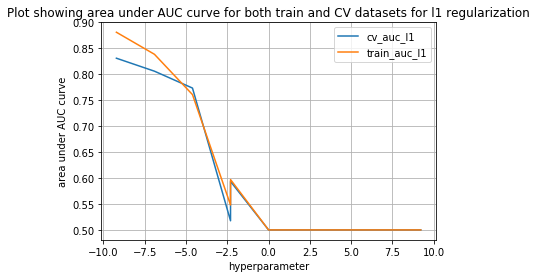

In [28]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_alpha,cv_roc_l1,label = 'cv_auc_l1')
plt.plot(log_alpha,train_roc_l1,label = 'train_auc_l1')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets for l1 regularization")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for 'L1' regularization as value of alpha increases the area under ROC curve decreases. For log(alpha) > -5 the area under curve for train data is overlapping the area under roc curve for cross validation data.</pre>

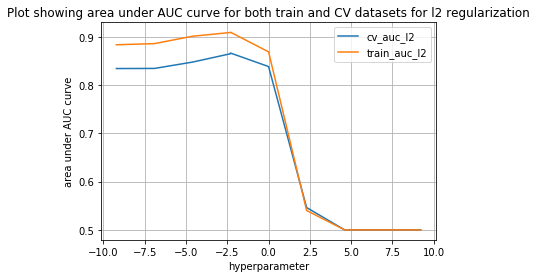

In [29]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_alpha,cv_roc_l2,label = 'cv_auc_l2')
plt.plot(log_alpha,train_roc_l2,label = 'train_auc_l2')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets for l2 regularization")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for 'L2' regularization as value of alpha increases the area under ROC curve decreases. For log(alpha) > -0 the area under curve for train data is overlapping the area under roc curve for cross validation data.</pre>

In [30]:
#From above we found the best values of alpha and penality are repectively . Therefor we will now test our model on our test dataset.
lr_svm = SGDClassifier(penalty = 'l2',alpha=0.1)
lr_svm.fit(standardized_train,y_train)
pred = lr_svm.predict(standardized_test)
print('For alpha = {0} and penality = {1}, the area under AUC curve is = {2}'.format(0.1,'l2',roc_auc_score(y_test, pred)))

For alpha = 0.1 and penality = l2, the area under AUC curve is = 0.8607482399947163


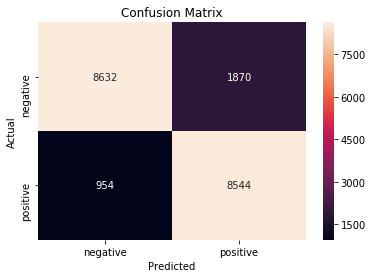

_____________________________________________________________________________________________________

For alpha = 0.1 and penalty = l2, the TPR = 89.9557801642451, TNR = 82.19386783469815, FPR = 17.806132165301847, FNR = 10.044219835754896


In [31]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor alpha = {0} and penalty = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(0.1,'l2',TPR,TNR,FPR,FNR))

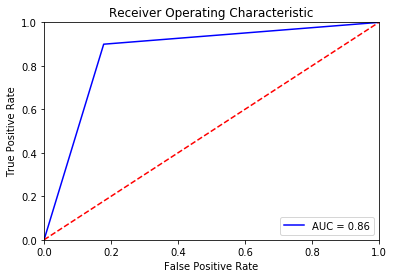

In [32]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:
<pre>From above we can see that area under roc curve is greater than 50%, therefore our model is better than simple mean model.</pre>

In [33]:
#function to get important features
def most_important_features(model, clf, n=10):
    feature_names = model.get_feature_names()#Here I am getting feature names stored in my model
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) #Here I am trying to create a sorted list containing tuples of-
    #-the form (prob,feature_name)
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])#here I am selecting top n important words-
    #- corresponding to positive class and bottom n words corresponding to negative class
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
most_important_features(model,lr_svm)
#Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-0.1924	disappoint     				0.2384	great          
	-0.1182	worst          				0.1852	best           
	-0.1072	terribl        				0.1837	love           
	-0.1068	aw             				0.1543	delici         
	-0.1005	horribl        				0.1424	good           
	-0.0974	bad            				0.1221	perfect        
	-0.0966	tast           				0.1165	excel          
	-0.0943	return         				0.1036	favorit        
	-0.0939	bland          				0.0950	nice           
	-0.0912	unfortun       				0.0835	easi           


### [2.2] Applying RBF Kernal SVM on BOW

In [34]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer = CountVectorizer(min_df = 10, max_features = 500) #defining our BOW model here. Here we are considering-
#- words which occur more than 10 times in our document and we are keeping the number of features = 500
model = vectorizer.fit(x_train_1)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train_1
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'pick': 321, 'market': 263, 'work': 488, 'also': 11, 'real': 354, 'feel': 163, 'chip': 76, 'excel': 146, 'green': 193, 'best': 38, 'organ': 305, 'year': 495, 'dog': 124, 'bite': 42, 'purchas': 346, 'either': 131, 'pasta': 313, 'part': 311, 'went': 480, 'cereal': 70, 'surpris': 431, 'gummi': 198, 'never': 284, 'life': 246, 'famili': 156, 'altern': 12, 'differ': 118, 'mouth': 277, 'seem': 386, 'splenda': 415, 'butter': 55, 'chicken': 75, 'hot': 213, 'sweet': 432, 'etc': 139, 'husband': 217, 'chocol': 77, 'definit': 114, 'wouldnt': 493, 'low': 258, 'suppos': 429, 'ago': 8, 'normal': 290, 'replac': 364, 'bake': 30, 'dont': 125, 'ground': 195, 'eat': 130, 'tell': 439, 'abl': 0, 'experi': 150, 'dish': 122, 'unfortun': 464, 'total': 455, 'cup': 106, 'away': 26, 'note': 291, 'qualiti': 348, 'orang': 303, 'plus': 327, 'bottl': 47, 'consum': 93, 'rich': 369, 'salad': 374, 'vanilla': 468, 'son': 409, 'problem': 340, 'long': 253, 'includ': 221, 'drink': 127, 'ship': 395, 'throw': 450, 'carb': 65,

In [35]:
train_bow = model.transform(x_train_1)#converting the internal parameters(i.e vocab) into vectors
cv_bow = model.transform(x_cv_1)# using the same vocab of x_train_1 I am transforming the text in x_cv_1 into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_bow = model.transform(x_test_1)# using the same vocab of x_train I am transforming the text in x_test_1 into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [36]:
#here we are creating a dataframe out of train_bow,cv_bow and test_bow
train_bow_df = pd.DataFrame(train_bow.toarray(),columns = model.get_feature_names())
cv_bow_df = pd.DataFrame(cv_bow.toarray(),columns = model.get_feature_names())
test_bow_df = pd.DataFrame(test_bow.toarray(),columns = model.get_feature_names())

In [37]:
#Here we are standardizing dataframes train_bow_df, cv_bow_df and test_bow_df
standardized_train = StandardScaler().fit_transform(train_bow_df)
standardized_cv = StandardScaler().fit_transform(cv_bow_df)
standardized_test = StandardScaler().fit_transform(test_bow_df)

In [38]:
standardized_train.shape

(5000, 500)

In [39]:
#Here we are trying to find area under AUC score  for train dataset for various values of-
#- C using SVC
train_roc = []
C = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
for i in C:
    rbf_svm = SVC(C=i)
    rbf_svm.fit(standardized_train,y_train_1)
    pred = rbf_svm.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train_1, pred))#roc_auc_score calculates area under the roc curve 

In [41]:
#performing simple cross validation using SVC for various values of C. Our metrics are-
#- area under auc curve.
cv_roc = []
C = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
for i in C:
    rbf_svm = SVC(C=i)
    rbf_svm.fit(standardized_train,y_train_1)
    pred = rbf_svm.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv_1, pred))#roc_auc_score calculates area under the roc curve 
    print('\nFor C = {0}, the area under AUC curve is = {1}'.format(i,roc_auc_score(y_cv_1, pred)))


For C = 10000, the area under AUC curve is = 0.5

For C = 1000, the area under AUC curve is = 0.49940547048137324

For C = 100, the area under AUC curve is = 0.49953976262008687

For C = 10, the area under AUC curve is = 0.5

For C = 1, the area under AUC curve is = 0.5

For C = 0.1, the area under AUC curve is = 0.5

For C = 0.1, the area under AUC curve is = 0.5

For C = 0.01, the area under AUC curve is = 0.5

For C = 0.001, the area under AUC curve is = 0.5

For C = 0.0001, the area under AUC curve is = 0.5


#### Observation:
<pre>From above we can see that we are getting simple mean model for every every possible value of C as AUC score is 0.5 for approximately each value of C. Here I am picking C = 0.1 as my hyperparameter</pre>

In [42]:
# Taking log of C values
log_c = np.log(np.array(C))
log_c

array([ 9.21034037,  6.90775528,  4.60517019,  2.30258509,  0.        ,
       -2.30258509, -2.30258509, -4.60517019, -6.90775528, -9.21034037])

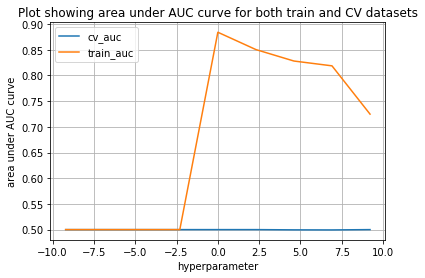

In [43]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for log(C) > -2.5 the area under ROC curve for training dataset increases exponentially where as for cross validation dataset the area under ROC curve remains constant at 0.5. This means our model is a overfitted model.</pre>

In [49]:
#From above we found the best value of C = 0.1. Therefor we will now test our model on our test dataset.
rbf_svm = SVC(C=0.1)
rbf_svm.fit(standardized_train,y_train_1)
pred = rbf_svm.predict(standardized_test)
print('For C = {0}, the area under AUC curve is = {1}'.format(0.1,roc_auc_score(y_test_1, pred)))

For C = 0.1, the area under AUC curve is = 0.5


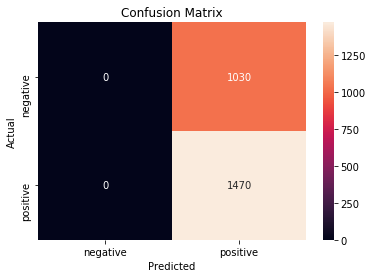

_____________________________________________________________________________________________________

For C = 0.1, the TPR = 100.0, TNR = 0.0, FPR = 100.0, FNR = 0.0


In [50]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test_1,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.1,TPR,TNR,FPR,FNR))

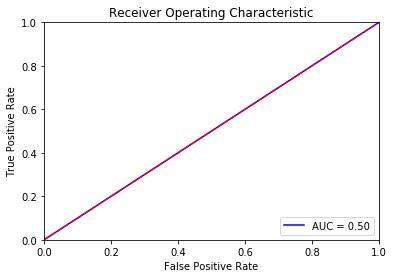

In [51]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test_1, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:
<pre>From above we can see that area under roc curve is exactly  50%, therefore our model is same as simple mean model.</pre>

# 3. TF-IDF

In [57]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer(min_df = 10)#defining our tf-idf model.
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'unsaf': 6445, 'array': 287, 'instinct': 3120, 'slipperi': 5484, 'lesser': 3446, 'cancer': 864, 'gardenia': 2495, 'sauc': 5190, 'theyv': 6124, 'frother': 2444, 'roof': 5093, 'petsmart': 4454, 'phosphorus': 4469, 'tub': 6323, 'devast': 1665, 'purpos': 4771, 'happier': 2766, 'snag': 5526, 'pebbl': 4385, 'quencher': 4794, 'macaroon': 3592, 'unsavori': 6450, 'effort': 1957, 'zone': 6891, 'heavili': 2832, 'real': 4861, 'gasolin': 2502, 'gumbal': 2725, 'protein': 4723, 'mother': 3909, 'stat': 5739, 'multitud': 3943, 'feel': 2225, 'steer': 5754, 'clinic': 1149, 'chip': 1061, 'swheat': 5956, 'degre': 1598, 'leatheri': 3418, 'hurrican': 2973, 'someplac': 5577, 'indiana': 3060, 'excel': 2099, 'pamela': 4310, 'father': 2195, 'wholefood': 6725, 'sri': 5708, 'salami': 5159, 'puf': 4742, 'trident': 6300, 'china': 1058, 'tame': 6002, 'wrapper': 6806, 'strengthen': 5814, 'glorious': 2573, 'starkist': 5733, 'best': 534, 'process': 4690, 'decay': 1560, 'unusu': 6460, 'proceed': 4689, 'disturb': 1789, '

In [58]:
train_tfidf = model.transform(x_train)#here we are using the internal parameters we learnt above to convert our reviews 
#- in x_train into matrices
cv_tfidf = model.transform(x_cv)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_cv into matrices
test_tfidf = model.transform(x_test)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_test into matrices

In [59]:
#here we are first creating a dataframes out of train_tfidf, cv_tfidf and test_tfidf
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(),columns = model.get_feature_names())
cv_tfidf_df = pd.DataFrame(cv_tfidf.toarray(),columns = model.get_feature_names())
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(),columns = model.get_feature_names())

In [60]:
#here we are creating standardized train, standardized cv and standardized test matrices
standardized_train = StandardScaler().fit_transform(train_tfidf_df)
standardized_cv = StandardScaler().fit_transform(cv_tfidf_df)
standardized_test = StandardScaler().fit_transform(test_tfidf_df)

In [61]:
standardized_train.shape

(60000, 6895)

### [3.1] Applying Linear SVM on TFIDF

In [62]:
#Here we are trying to find area under AUC score  for train dataset for various values of-
#-alpha and penality using SGD Classifier
train_roc_l1 = []
train_roc_l2 = []
alpha = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
penality = ['l1','l2']
for i in penality:
    for j in alpha:
        lr_svm = SGDClassifier(penalty = i,alpha=j)
        lr_svm.fit(standardized_train,y_train)
        pred = lr_svm.predict(standardized_train)
        if i=='l1':
            train_roc_l1.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 
        if i=='l2':
            train_roc_l2.append(roc_auc_score(y_train, pred))

In [63]:
#performing simple cross validation using SGD Classifier for various values of alpha and penalty. Our metrics are-
#- area under auc curve.
cv_roc_l1 = []
cv_roc_l2 = []
alpha = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
penality = ['l1','l2']
for i in penality:
    for j in alpha:
        lr_svm = SGDClassifier(penalty = i,alpha=j)
        lr_svm.fit(standardized_train,y_train)
        pred = lr_svm.predict(standardized_cv)
        if i=='l1':
            cv_roc_l1.append(roc_auc_score(y_cv, pred))#roc_auc_score calculates area under the roc curve 
        if i=='l2':
            cv_roc_l2.append(roc_auc_score(y_cv, pred)) 
        print('\nFor alpha = {0} and penality = {1}, the area under AUC curve is = {2}'.format(j,i,roc_auc_score(y_cv, pred)))


For alpha = 10000 and penality = l1, the area under AUC curve is = 0.5

For alpha = 1000 and penality = l1, the area under AUC curve is = 0.5

For alpha = 100 and penality = l1, the area under AUC curve is = 0.5

For alpha = 10 and penality = l1, the area under AUC curve is = 0.5

For alpha = 1 and penality = l1, the area under AUC curve is = 0.5

For alpha = 0.1 and penality = l1, the area under AUC curve is = 0.5524094202898551

For alpha = 0.1 and penality = l1, the area under AUC curve is = 0.5344223027375201

For alpha = 0.01 and penality = l1, the area under AUC curve is = 0.762999194847021

For alpha = 0.001 and penality = l1, the area under AUC curve is = 0.8107950885668278

For alpha = 0.0001 and penality = l1, the area under AUC curve is = 0.832878421900161

For alpha = 10000 and penality = l2, the area under AUC curve is = 0.5

For alpha = 1000 and penality = l2, the area under AUC curve is = 0.5

For alpha = 100 and penality = l2, the area under AUC curve is = 0.5

For alp

#### Observation:
<pre>From above we can see that we are getting maximum AUC for alpha = 1, penality = l2. Therefore now we will use these two values of hyperparameters on our test dataset.</pre>

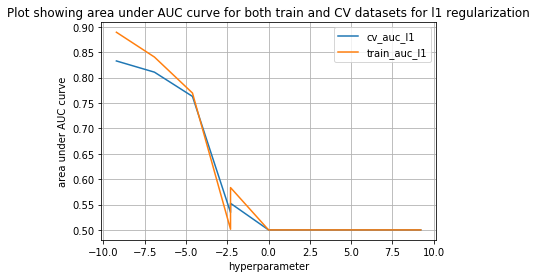

In [64]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_alpha,cv_roc_l1,label = 'cv_auc_l1')
plt.plot(log_alpha,train_roc_l1,label = 'train_auc_l1')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets for l1 regularization")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for l1 regularization as log(alpha) increases the area under the roc curve for both training and cross validation dataset decreases exponentially and becomes constant 0.5 for log(alpha)>0</pre>

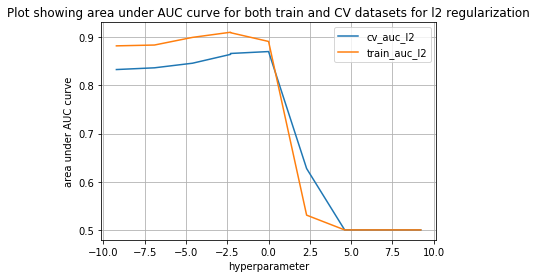

In [65]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_alpha,cv_roc_l2,label = 'cv_auc_l2')
plt.plot(log_alpha,train_roc_l2,label = 'train_auc_l2')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets for l2 regularization")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for l2 regularization as log(alpha) increases the area under the roc curve for both training and cross validation dataset decreases exponentially and becomes constant 0.5 for log(alpha)>5</pre>

In [68]:
#From above we found the best value of alpha and penality are respectively. Therefor we will now test our model on our test dataset.
lr_svm = SGDClassifier(penalty = 'l2',alpha=1)
lr_svm.fit(standardized_train,y_train)
pred = lr_svm.predict(standardized_test)
print('For alpha = {0} and penality = {1}, the area under AUC curve is = {2}'.format(1,'l2',roc_auc_score(y_test, pred)))

For alpha = 1 and penality = l2, the area under AUC curve is = 0.8532885713312978


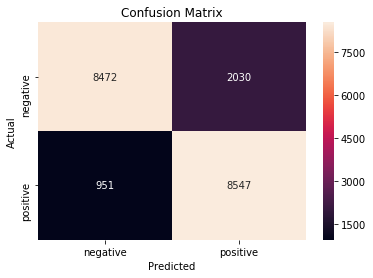

_____________________________________________________________________________________________________

For alpha = 1 and penalty = l2, the TPR = 89.98736576121289, TNR = 80.67034850504666, FPR = 19.329651494953342, FNR = 10.012634238787113


In [69]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor alpha = {0} and penalty = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(1,'l2',TPR,TNR,FPR,FNR))

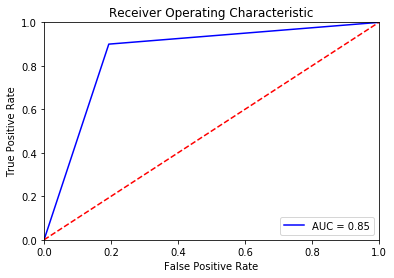

In [70]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:
<pre>From above plot we can see that our model is better than a simple mean model as area under roc curve > 0.5</pre>

In [71]:
most_important_features(model,lr_svm)#getting important features

			Positive						Negative
________________________________________________________________________________________________
	-0.0788	disappoint     				0.0936	great          
	-0.0457	worst          				0.0789	love           
	-0.0447	bad            				0.0729	best           
	-0.0419	terribl        				0.0587	delici         
	-0.0417	thought        				0.0540	good           
	-0.0413	aw             				0.0490	perfect        
	-0.0405	didnt          				0.0441	excel          
	-0.0398	would          				0.0437	favorit        
	-0.0396	tast           				0.0405	nice           
	-0.0395	wast           				0.0386	find           


### [3.2] Applying RBF Kernal SVM on TFIDF

In [72]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer(min_df = 10, max_features = 500)#defining our tf-idf model and considering only those words-
#-which occur more than 10 times in our document and maximum features = 500
model = vectorizer.fit(x_train_1)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'pick': 321, 'market': 263, 'work': 488, 'also': 11, 'real': 354, 'feel': 163, 'chip': 76, 'excel': 146, 'green': 193, 'best': 38, 'organ': 305, 'year': 495, 'dog': 124, 'bite': 42, 'purchas': 346, 'either': 131, 'pasta': 313, 'part': 311, 'went': 480, 'cereal': 70, 'surpris': 431, 'gummi': 198, 'never': 284, 'life': 246, 'famili': 156, 'altern': 12, 'differ': 118, 'mouth': 277, 'seem': 386, 'splenda': 415, 'butter': 55, 'chicken': 75, 'hot': 213, 'sweet': 432, 'etc': 139, 'husband': 217, 'chocol': 77, 'definit': 114, 'wouldnt': 493, 'low': 258, 'suppos': 429, 'ago': 8, 'normal': 290, 'replac': 364, 'bake': 30, 'dont': 125, 'ground': 195, 'eat': 130, 'tell': 439, 'abl': 0, 'experi': 150, 'dish': 122, 'unfortun': 464, 'total': 455, 'cup': 106, 'away': 26, 'note': 291, 'qualiti': 348, 'orang': 303, 'plus': 327, 'bottl': 47, 'consum': 93, 'rich': 369, 'salad': 374, 'vanilla': 468, 'son': 409, 'problem': 340, 'long': 253, 'includ': 221, 'drink': 127, 'ship': 395, 'throw': 450, 'carb': 65,

In [73]:
train_tfidf = model.transform(x_train_1)#converting the internal parameters(i.e vocab) into vectors
cv_tfidf = model.transform(x_cv_1)# using the same vocab of x_train_1 I am transforming the text in x_cv_1 into tfidf matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_tfidf = model.transform(x_test_1)# using the same vocab of x_train_1 I am transforming the text in x_test_1 into tfidf matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [74]:
#here we are creating a dataframe out of train_tfidf,cv_tfidf and test_tfidf
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(),columns = model.get_feature_names())
cv_tfidf_df = pd.DataFrame(cv_tfidf.toarray(),columns = model.get_feature_names())
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(),columns = model.get_feature_names())

In [75]:
#Here we are standardizing dataframes train_bow_df, cv_bow_df and test_bow_df
standardized_train = StandardScaler().fit_transform(train_tfidf_df)
standardized_cv = StandardScaler().fit_transform(cv_tfidf_df)
standardized_test = StandardScaler().fit_transform(test_tfidf_df)

In [76]:
standardized_train.shape

(5000, 500)

In [86]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
for i in C:
    rbf_svm = SVC(C=i)
    rbf_svm.fit(standardized_train,y_train_1)
    pred = rbf_svm.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train_1, pred))#roc_auc_score calculates area under the roc curve 

In [87]:
#performing simple cross validation using SVC for various values of C. Our metrics are-
#- area under auc curve.
cv_roc = []
C = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
for i in C:
    rbf_svm = SVC(C=i)
    rbf_svm.fit(standardized_train,y_train_1)
    pred = rbf_svm.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv_1, pred))#roc_auc_score calculates area under the roc curve 
    print('\nFor C = {0}, the area under AUC curve is = {1}'.format(i,roc_auc_score(y_cv_1, pred)))


For C = 10000, the area under AUC curve is = 0.5

For C = 1000, the area under AUC curve is = 0.5

For C = 100, the area under AUC curve is = 0.5

For C = 10, the area under AUC curve is = 0.5003259452411994

For C = 1, the area under AUC curve is = 0.5

For C = 0.1, the area under AUC curve is = 0.5

For C = 0.1, the area under AUC curve is = 0.5

For C = 0.01, the area under AUC curve is = 0.5

For C = 0.001, the area under AUC curve is = 0.5

For C = 0.0001, the area under AUC curve is = 0.5


#### Observation:
<pre>From above we can see that we are getting maximum AUC for C = 10. Therefore now we will use this value of hyperparameter on our test dataset.</pre>

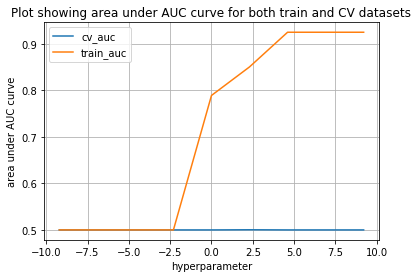

In [89]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for log(C) > -2.5 the area under ROC curve for training dataset increases exponentially where as for cross validation dataset the area under ROC curve remains constant at 0.5. This means our model is a overfitted model.</pre>

In [92]:
#From above we found the best value of C = 10. Therefor we will now test our model on our test dataset.
rbf_svm = SVC(C=10)
rbf_svm.fit(standardized_train,y_train_1)
pred = rbf_svm.predict(standardized_test)
print('For C = {0}, the area under AUC curve is = {1}'.format(10,roc_auc_score(y_test_1, pred)))

For C = 10, the area under AUC curve is = 0.5003401360544217


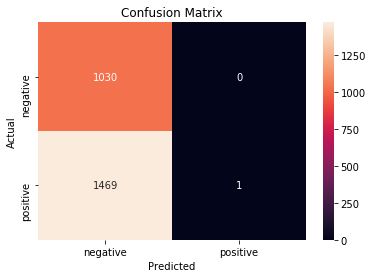

_____________________________________________________________________________________________________

For C = 0.01, the TPR = 0.06802721088435373, TNR = 100.0, FPR = 0.0, FNR = 99.93197278911565


In [93]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test_1,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.01,TPR,TNR,FPR,FNR))

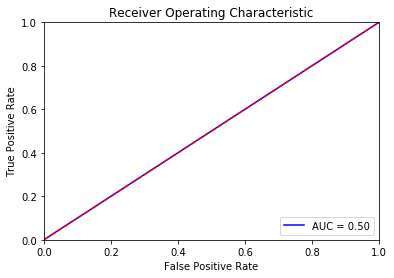

In [94]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test_1, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:
<pre>From above plot we can see that the area under roc curve = 0.5 and hence is same as a simple mean model.</pre>

# 4. Word2Vec (for Linear SVM)

In [95]:
#splitting each of my reviews in x_train into list of, list of stemmed words in each of our stemmed reviews in x_train
list_of_sent = []
for sent in x_train.values:
    list_of_sent.append(sent.split())

In [96]:
#splitting each of my reviews in x_cv into list of, list of stemmed words in each of our stemmed reviews in x_cv
list_of_sent_cv = []
for sent in x_cv.values:
    list_of_sent_cv.append(sent.split())

In [97]:
#splitting each of my reviews in x_test into list of, list of stemmed words in each of our stemmed reviews in x_test
list_of_sent_test = []
for sent in x_test.values:
    list_of_sent_test.append(sent.split())

In [98]:
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4) #Here I am creating word2vec representation of each of-
#- the words in my 'list_of_sent' list i.e I am creating w2v representation of words in reviews of x_train, where we-
#- are creating word2vec vectors for words in 'list_of_sent' list which-
#- occur >=5 times in the list. The number of dimensions of our word2ec vectors = 50 and number of cores which will carry-
#- on the job parallely = 4
print(w2v_model) #returns an iterator
#to see which words exist in our w2v-model
w2v_words = list(w2v_model.wv.vocab)#Here we are creating list of words, which are keys in dictionary 'w2v_model.wv.vocab'.
print(w2v_words)

Word2Vec(vocab=10422, size=50, alpha=0.025)
['unsaf', 'soldier', 'ziggi', 'speckl', 'lesser', 'array', 'senior', 'puffin', 'sniff', 'finland', 'somewhat', 'free', 'municip', 'instinct', 'slipperi', 'loc', 'genesi', 'ooh', 'acclim', 'mediev', 'lou', 'whack', 'mirror', 'hyperact', 'cancer', 'gardenia', 'tequila', 'promin', 'market', 'yanke', 'gassi', 'sauc', 'theyv', 'woe', 'frother', 'hydrat', 'gopicn', 'gram', 'roof', 'petsmart', 'phosphorus', 'highland', 'scrap', 'futil', 'tub', 'holl', 'pollux', 'plantat', 'reali', 'overkil', 'warm', 'devast', 'encas', 'purpos', 'exper', 'ken', 'puchas', 'delfa', 'cite', 'unscrew', 'happier', 'snag', 'osmanthus', 'unexcit', 'afterward', 'pebbl', 'sahal', 'sojo', 'namesak', 'insipid', 'eric', 'sicken', 'vermouth', 'bough', 'educ', 'philosophi', 'demolish', 'quencher', 'ceas', 'neighbour', 'roastaroma', 'grin', 'nurseri', 'agav', 'overfe', 'macaroon', 'memphi', 'ballpark', 'unsavori', 'bow', 'sustain', 'sterol', 'daycar', 'matcha', 'ortho', 'ditch', 'p

## 4.1 Average Word2Vec

In [99]:
#average word2vec for each review in x_train
sent_vectors = []
for sent in tqdm(list_of_sent): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_train
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 60000/60000 [07:38<00:00, 130.82it/s]

60000
50


In [100]:
#average word2vec for each review in x_cv
sent_vectors_cv = []
for sent in tqdm(list_of_sent_cv): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_cv'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_cv
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 20000/20000 [02:28<00:00, 134.67it/s]

20000
50


In [101]:
#average word2vec for each review in x_test
sent_vectors_test = []
for sent in tqdm(list_of_sent_test): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_test'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_test
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 20000/20000 [02:31<00:00, 188.19it/s]

20000
50


In [102]:
#here we are first creating a dataframe out of sent_vectors, sent_vectors_cv, sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(sent_vectors)
tfidf_w2v_cv = pd.DataFrame(sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(sent_vectors_test)

In [103]:
#here we are standardizing the train, cv and test dataframes created above
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

In [104]:
standardized_train.shape

(60000, 50)

### [4.1.1]  Applying Linear SVM on AVG W2V

In [105]:
#Here we are trying to find area under AUC score  for train dataset for various values of-
#- alpha and penalty using SGD Classifier
train_roc_l1 = []
train_roc_l2 = []
alpha = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
penality = ['l1','l2']
for i in penality:
    for j in alpha:
        lr_svm = SGDClassifier(penalty = i,alpha=j)
        lr_svm.fit(standardized_train,y_train)
        pred = lr_svm.predict(standardized_train)
        if i=='l1':
            train_roc_l1.append(roc_auc_score(y_train, pred))
        elif i=='l2':
            train_roc_l2.append(roc_auc_score(y_train, pred))

In [106]:
#performing simple cross validation using SGD Classifier for various values of alpha and penality. Our metrics are-
#- area under auc curve
cv_roc_l1 = []
cv_roc_l2 = []
alpha = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
penality = ['l1','l2']
for i in penality:
    for j in alpha:
        lr_svm = SGDClassifier(penalty = i,alpha=j)
        lr_svm.fit(standardized_train,y_train)
        pred = lr_svm.predict(standardized_cv)
        if i=='l1':
            cv_roc_l1.append(roc_auc_score(y_cv, pred))
        elif i=='l2':
            cv_roc_l2.append(roc_auc_score(y_cv, pred))
        print('\nFor alpha = {0} and penality = {1}, the area under AUC curve is = {2}'.format(j,i,roc_auc_score(y_cv, pred)))


For alpha = 10000 and penality = l1, the area under AUC curve is = 0.5

For alpha = 1000 and penality = l1, the area under AUC curve is = 0.5

For alpha = 100 and penality = l1, the area under AUC curve is = 0.5

For alpha = 10 and penality = l1, the area under AUC curve is = 0.5

For alpha = 1 and penality = l1, the area under AUC curve is = 0.5

For alpha = 0.1 and penality = l1, the area under AUC curve is = 0.7764935587761674

For alpha = 0.1 and penality = l1, the area under AUC curve is = 0.7735124798711756

For alpha = 0.01 and penality = l1, the area under AUC curve is = 0.8317089371980677

For alpha = 0.001 and penality = l1, the area under AUC curve is = 0.8276570048309179

For alpha = 0.0001 and penality = l1, the area under AUC curve is = 0.8158011272141708

For alpha = 10000 and penality = l2, the area under AUC curve is = 0.5

For alpha = 1000 and penality = l2, the area under AUC curve is = 0.5

For alpha = 100 and penality = l2, the area under AUC curve is = 0.5

For a

#### Observation:
<pre>From above we can see that we are getting maximum AUC for alpha = 0.001, penality = l2. Therefore now we will use these two values of hyperparameters on our test dataset.</pre>

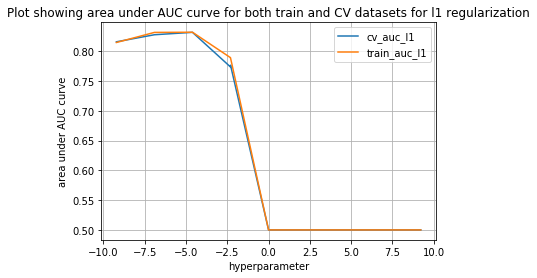

In [109]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_alpha,cv_roc_l1,label = 'cv_auc_l1')
plt.plot(log_alpha,train_roc_l1,label = 'train_auc_l1')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets for l1 regularization")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for l1 regularization as log(alpha) increases the area under ROC curve for training dataset cross validation dataset decreases exponentially and for log(alpha) > 0 the area under roc curve for both train and cv dataset becomes constant and equal to 0.5.</pre>

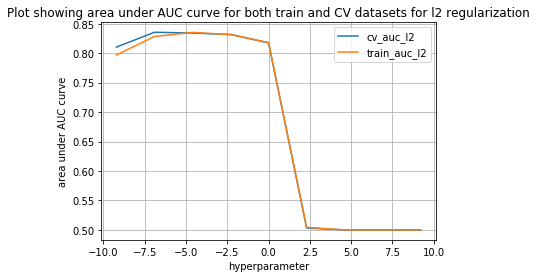

In [110]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_alpha,cv_roc_l2,label = 'cv_auc_l2')
plt.plot(log_alpha,train_roc_l2,label = 'train_auc_l2')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets for l2 regularization")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for l2 regularization as log(alpha) increases the area under ROC curve for training dataset cross validation dataset decreases exponentially and for log(alpha) > 2.5 the area under roc curve for both train and cv dataset becomes constant and equal to 0.5.</pre>

In [112]:
#From above we found the best value of alpha and penalty are respectively. Therefor we will now test our model on our test dataset.
lr_svm = SGDClassifier(penalty = 'l2',alpha=0.001)
lr_svm.fit(standardized_train,y_train)
pred = lr_svm.predict(standardized_test)
print('For alpha = {0} and penality = {1}, the area under AUC curve is = {2}'.format(0.001,'l2',roc_auc_score(y_test, pred)))

For alpha = 0.001 and penality = l2, the area under AUC curve is = 0.8271666330018299


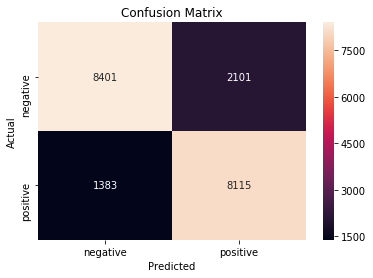

_____________________________________________________________________________________________________

For alpha = 0.001 and penalty = l2, the TPR = 85.43903979785217, TNR = 79.9942868025138, FPR = 20.005713197486195, FNR = 14.560960202147822


In [113]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor alpha = {0} and penalty = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(0.001,'l2',TPR,TNR,FPR,FNR))

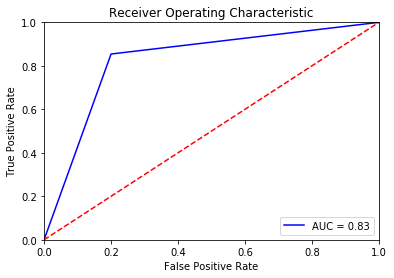

In [114]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:
<pre>From above plot we can see our model is better than simple mean model as are under ROC curve is greater than 0.5</pre>

## 4.2 Weighted Word2Vec

In [115]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer()#defining our tf-idf model
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'unsaf': 27814, 'xray': 29519, 'importfood': 12866, 'array': 1401, 'prestigi': 20381, 'enrob': 8556, 'insensit': 13217, 'apartheid': 1166, 'finland': 9553, 'conflat': 5575, 'sidamo': 23548, 'instinct': 13250, 'slipperi': 23834, 'eligbl': 8327, 'lesser': 14800, 'descpript': 7006, 'acronym': 207, 'blameless': 2685, 'irrigular': 13462, 'culmin': 6329, 'hdmi': 11848, 'cancer': 3805, 'gardenia': 10473, 'unuasu': 27911, 'incoher': 12950, 'sauc': 22701, 'theyv': 26304, 'noc': 17660, 'woe': 29293, 'frother': 10236, 'chocolat': 4747, 'ecosystem': 8147, 'unadvertis': 27383, 'bastion': 2068, 'roof': 22231, 'petsmart': 19486, 'wantn': 28662, 'repond': 21758, 'phosphorus': 19573, 'senegales': 23105, 'solopress': 24149, 'gorgonzola': 11057, 'creamy': 6100, 'tub': 27143, 'devast': 7089, 'purpos': 20866, 'truffel': 27091, 'bonnat': 2941, 'pecorino': 19223, 'patrol': 19133, 'happier': 11703, 'snag': 23982, 'tossd': 26783, 'unexcit': 27586, 'pebbl': 19215, 'sahal': 22488, 'namesak': 17251, 'pemprok': 1

In [116]:
#creating dictionary, where keys are words in our dataset and values are their corresponding idf values
dictionary_1 = dict(zip(model.get_feature_names(),list(model.idf_)))

In [117]:
#Weighted word2vec for x_train
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|██████████| 60000/60000 [08:02<00:00, 124.23it/s]

60000
50


In [118]:
#Weighted word2vec for x_cv
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_cv))
print(len(tfidf_sent_vectors_cv[0]))

100%|██████████| 20000/20000 [02:37<00:00, 126.85it/s]

20000
50


In [119]:
#Weighted word2vec for x_test
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|██████████| 20000/20000 [02:38<00:00, 125.90it/s]

20000
50


In [120]:
#here we are first creating a dataframes out of tfidf_sent_vectors_train, tfidf_sent_vectors_cv and tfidf_sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(tfidf_sent_vectors_train)
tfidf_w2v_cv = pd.DataFrame(tfidf_sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(tfidf_sent_vectors_test)

In [121]:
#standardizing the dataframes created above
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

### [4.2.1]  Applying Linear SVM on TFIDF W2V,

In [122]:
#Here we are trying to find area under AUC score  for train dataset for various values of-
#- alpha and penalty using SGD Classifier
train_roc_l1 = []
train_roc_l2 = []
alpha = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
penality = ['l1','l2']
for i in penality:
    for j in alpha:
        lr_svm = SGDClassifier(penalty = i,alpha=j)
        lr_svm.fit(standardized_train,y_train)
        pred = lr_svm.predict(standardized_train)
        if i=='l1':
            train_roc_l1.append(roc_auc_score(y_train, pred))
        elif i=='l2':
            train_roc_l2.append(roc_auc_score(y_train, pred))

In [123]:
#performing simple cross validation using SGD Classifier for various values of alpha and penality. Our metrics are-
#- area under auc curve
cv_roc_l1 = []
cv_roc_l2 = []
alpha = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
penality = ['l1','l2']
for i in penality:
    for j in alpha:
        lr_svm = SGDClassifier(penalty = i,alpha=j)
        lr_svm.fit(standardized_train,y_train)
        pred = lr_svm.predict(standardized_cv)
        if i=='l1':
            cv_roc_l1.append(roc_auc_score(y_cv, pred))
        elif i=='l2':
            cv_roc_l2.append(roc_auc_score(y_cv, pred))
        print('\nFor alpha = {0} and penality = {1}, the area under AUC curve is = {2}'.format(j,i,roc_auc_score(y_cv, pred)))


For alpha = 10000 and penality = l1, the area under AUC curve is = 0.5

For alpha = 1000 and penality = l1, the area under AUC curve is = 0.5

For alpha = 100 and penality = l1, the area under AUC curve is = 0.5

For alpha = 10 and penality = l1, the area under AUC curve is = 0.5

For alpha = 1 and penality = l1, the area under AUC curve is = 0.5

For alpha = 0.1 and penality = l1, the area under AUC curve is = 0.7429971819645733

For alpha = 0.1 and penality = l1, the area under AUC curve is = 0.7347262479871175

For alpha = 0.01 and penality = l1, the area under AUC curve is = 0.8009923510466989

For alpha = 0.001 and penality = l1, the area under AUC curve is = 0.7992451690821256

For alpha = 0.0001 and penality = l1, the area under AUC curve is = 0.7637479871175523

For alpha = 10000 and penality = l2, the area under AUC curve is = 0.5

For alpha = 1000 and penality = l2, the area under AUC curve is = 0.5

For alpha = 100 and penality = l2, the area under AUC curve is = 0.5

For a

#### Observation:
<pre>From above we can see that we are getting maximum AUC for alpha = 0.01, penality = l2. Therefore now we will use these two values of hyperparameters on our test dataset.</pre>

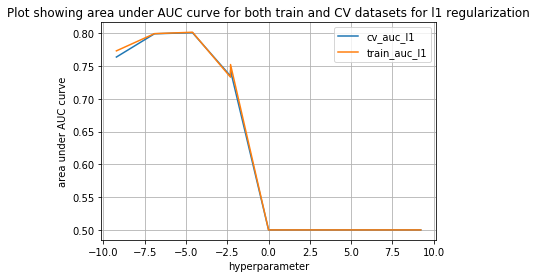

In [124]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_alpha,cv_roc_l1,label = 'cv_auc_l1')
plt.plot(log_alpha,train_roc_l1,label = 'train_auc_l1')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets for l1 regularization")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for l1 regularization as log(alpha) increases the area under ROC curve for training dataset cross validation dataset decreases exponentially and for log(alpha) > 0 the area under roc curve for both train and cv dataset becomes constant and equal to 0.5.</pre>

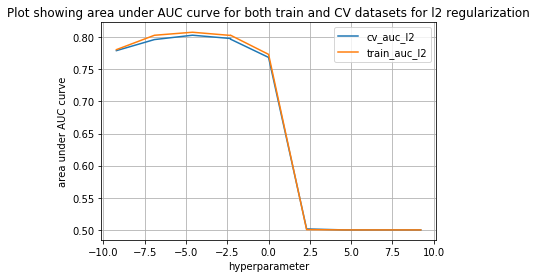

In [125]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_alpha,cv_roc_l2,label = 'cv_auc_l2')
plt.plot(log_alpha,train_roc_l2,label = 'train_auc_l2')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets for l2 regularization")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that for l1 regularization as log(alpha) increases the area under ROC curve for training dataset cross validation dataset decreases exponentially and for log(alpha) > 2.5 the area under roc curve for both train and cv dataset becomes constant and equal to 0.5.</pre>

In [127]:
#From above we found the best value of alpha and penalty are respectively. Therefor we will now test our model on our test dataset.
lr_svm = SGDClassifier(penalty = 'l2',alpha=0.01)
lr_svm.fit(standardized_train,y_train)
pred = lr_svm.predict(standardized_test)
print('For alpha = {0} and penality = {1}, the area under AUC curve is = {2}'.format(0.01,'l2',roc_auc_score(y_test, pred)))

For alpha = 0.01 and penality = l2, the area under AUC curve is = 0.7993909070614311


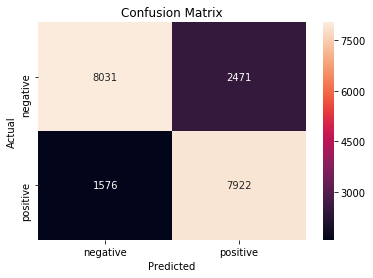

_____________________________________________________________________________________________________

For alpha = 0.01 and penalty = l2, the TPR = 83.4070330595915, TNR = 76.47114835269473, FPR = 23.528851647305274, FNR = 16.59296694040851


In [128]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor alpha = {0} and penalty = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(0.01,'l2',TPR,TNR,FPR,FNR))

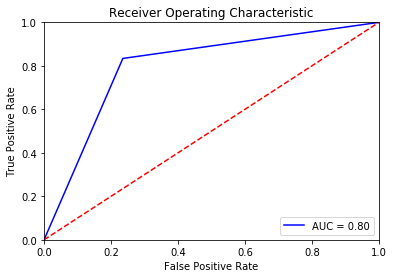

In [129]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation
<pre>From above plot we can see that as area under roc curve > 0.5 therefore our model is better than simple mean model.</pre>

# 5. Word2Vec (for RBF SVM)

In [130]:
#splitting each of my reviews in x_train_1 into list of, list of stemmed words in each of our stemmed reviews in x_train_1
list_of_sent = []
for sent in x_train_1.values:
    list_of_sent.append(sent.split())

In [131]:
#splitting each of my reviews in x_cv_1 into list of, list of stemmed words in each of our stemmed reviews in x_cv_1
list_of_sent_cv = []
for sent in x_cv_1.values:
    list_of_sent_cv.append(sent.split())

In [132]:
#splitting each of my reviews in x_test_1 into list of, list of stemmed words in each of our stemmed reviews in x_test_1
list_of_sent_test = []
for sent in x_test_1.values:
    list_of_sent_test.append(sent.split())

In [133]:
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4) #Here I am creating word2vec representation of each of-
#- the words in my 'list_of_sent' list i.e I am creating w2v representation of words in reviews of x_train, where we-
#- are creating word2vec vectors for words in 'list_of_sent' list which-
#- occur >=5 times in the list. The number of dimensions of our word2ec vectors = 50 and number of cores which will carry-
#- on the job parallely = 4
print(w2v_model) #returns an iterator
#to see which words exist in our w2v-model
w2v_words = list(w2v_model.wv.vocab)#Here we are creating list of words, which are keys in dictionary 'w2v_model.wv.vocab'.
print(w2v_words)

Word2Vec(vocab=3253, size=50, alpha=0.025)
['singl', 'greas', 'multipl', 'rush', 'yeast', 'sniff', 'orang', 'foul', 'lousi', 'gold', 'nightmar', 'cancer', 'gardenia', 'easi', 'board', 'pick', 'market', 'gas', 'extend', 'hydrat', 'adequ', 'rotor', 'subtl', 'thrill', 'aw', 'detail', 'froth', 'oreo', 'tub', 'wow', 'rind', 'powderi', 'purpos', 'beverag', 'inclin', 'thank', 'snob', 'teaspoon', 'fatigu', 'edensoy', 'horrid', 'varieti', 'mixer', 'educ', 'instead', 'roastaroma', 'agav', 'libbi', 'loav', 'notic', 'barrel', 'session', 'sorri', 'premium', 'matcha', 'harm', 'work', 'truth', 'aftertast', 'mccormick', 'diagnos', 'john', 'drank', 'choic', 'real', 'carbon', 'promis', 'zero', 'standard', 'tree', 'wake', 'tingl', 'receiv', 'gumbal', 'dissappoint', 'juli', 'money', 'grow', 'coconut', 'pete', 'prais', 'rebecca', 'turkey', 'heck', 'dairi', 'set', 'feel', 'calori', 'hell', 'million', 'proud', 'mistaken', 'vendor', 'brand', 'web', 'caveat', 'exercis', 'swheat', 'desk', 'degre', 'stair', 'fam

## 5.1 Average Word2Vec

In [134]:
#average word2vec for each review in x_train
sent_vectors = []
for sent in tqdm(list_of_sent): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_train
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:07<00:00, 712.62it/s]

5000
50


In [135]:
#average word2vec for each review in x_cv
sent_vectors_cv = []
for sent in tqdm(list_of_sent_cv): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_cv'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_cv
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 2500/2500 [00:03<00:00, 704.32it/s]

2500
50


In [136]:
#average word2vec for each review in x_test
sent_vectors_test = []
for sent in tqdm(list_of_sent_test): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_test'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_test
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 2500/2500 [00:03<00:00, 694.90it/s]

2500
50


In [137]:
#here we are first creating a dataframe out of sent_vectors, sent_vectors_cv, sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(sent_vectors)
tfidf_w2v_cv = pd.DataFrame(sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(sent_vectors_test)

In [138]:
#here we are standardizing the train, cv and test dataframes created above
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

In [139]:
standardized_train.shape

(5000, 50)

### [5.1.1]  Applying RBF SVM on AVG W2V

In [140]:
#Here we are trying to find area under AUC score for train dataset for various values of-
#- C using SVC
train_roc = []
C = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
for i in C:
    rbf_svm = SVC(C=i)
    rbf_svm.fit(standardized_train,y_train_1)
    pred = rbf_svm.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train_1, pred))#roc_auc_score calculates area under the roc curve 

In [143]:
#performing simple cross validation using SVC for various values of C. Our metrics are-
#- area under auc curve
cv_roc = []
C = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
for i in C:
    rbf_svm = SVC(C=i)
    rbf_svm.fit(standardized_train,y_train_1)
    pred = rbf_svm.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv_1, pred))#roc_auc_score calculates area under the roc curve 
    print('\nFor C = {0}, the area under AUC curve is = {1}'.format(i,roc_auc_score(y_cv_1, pred)))


For C = 10000, the area under AUC curve is = 0.52279794634253

For C = 1000, the area under AUC curve is = 0.5101630131106919

For C = 100, the area under AUC curve is = 0.5181969222131344

For C = 10, the area under AUC curve is = 0.5287236713176287

For C = 1, the area under AUC curve is = 0.5484450454973668

For C = 0.1, the area under AUC curve is = 0.4996740547588005

For C = 0.1, the area under AUC curve is = 0.4996740547588005

For C = 0.01, the area under AUC curve is = 0.5

For C = 0.001, the area under AUC curve is = 0.5

For C = 0.0001, the area under AUC curve is = 0.5


#### Observation:
<pre>From above we can see that we are getting maximum AUC for C = 1. Therefore now we will use this value of hyperparameter on our test dataset.</pre>

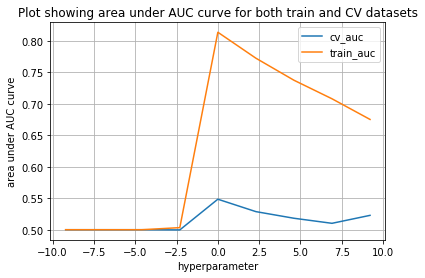

In [144]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that as log(C) increases the area under ROC curve for training dataset increases exponentially where as the area under roc curve for cross validation dataset remians approximately around 50 to 55% thus indicating that our model is a overfitted model.</pre>

In [147]:
#From above we found the best value of C = 1. Therefor we will now test our model on our test dataset.
rbf_svm = SVC(C=1)
rbf_svm.fit(standardized_train,y_train_1)
pred = rbf_svm.predict(standardized_test)
print('For C = {0}, the area under AUC curve is = {1}'.format(1,roc_auc_score(y_test_1, pred)))

For C = 1, the area under AUC curve is = 0.56852915923651


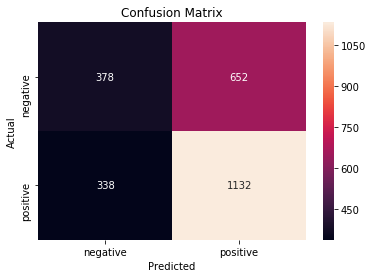

_____________________________________________________________________________________________________

For C = 0.01, the TPR = 77.00680272108843, TNR = 36.699029126213595, FPR = 63.30097087378641, FNR = 22.993197278911566


In [148]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test_1,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.01,TPR,TNR,FPR,FNR))

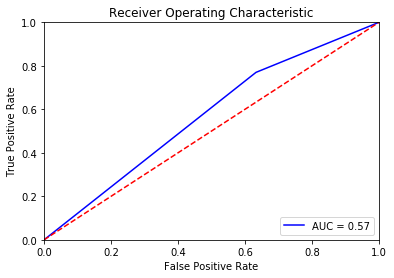

In [149]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test_1, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:
<pre>From above plot we can see that the area under roc curve is 0.57 and hence our model is slightly better than simple mean model.</pre>

## 5.2 Weighted Word2Vec

In [150]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer()#defining our tf-idf model 
model = vectorizer.fit(x_train_1)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'unsaf': 9102, 'lesser': 4882, 'culmin': 2067, 'mirror': 5449, 'opinion': 5972, 'insensit': 4399, 'finland': 3178, 'incompetit': 4291, 'dullest': 2623, 'slipperi': 7820, 'eligbl': 2753, 'caiman': 1176, 'baught': 671, 'array': 432, 'cancer': 1215, 'gardenia': 3478, 'porbabl': 6555, 'pick': 6392, 'market': 5194, 'yanke': 9687, 'runni': 7336, 'theyv': 8644, 'woe': 9592, 'hydrat': 4184, 'ecosystem': 2696, 'outreag': 6046, 'roof': 7289, 'petsmart': 6350, 'kindof': 4698, 'phosphorus': 6378, 'gorgonzola': 3659, 'tub': 8921, 'hull': 4160, 'devast': 2332, 'purpos': 6822, 'ken': 4662, 'happier': 3881, 'tossd': 8809, 'unexcit': 9044, 'pebbl': 6258, 'sahal': 7369, 'namesak': 5662, 'sicken': 7710, 'quencher': 6858, 'distant': 2477, 'agav': 141, 'macaroon': 5087, 'libbi': 4899, 'consequect': 1821, 'effort': 2718, 'herban': 3999, 'daycar': 2162, 'matcha': 5231, 'dunkin': 2633, 'work': 9615, 'guayucki': 3800, 'mik': 5395, 'also': 255, 'heavili': 3966, 'injur': 4383, 'devis': 2338, 'drank': 2568, 'sep

In [151]:
#creating dictionary, where keys are words in our dataset and values are their corresponding idf values
dictionary_1 = dict(zip(model.get_feature_names(),list(model.idf_)))

In [152]:
#Weighted word2vec for x_train
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|██████████| 5000/5000 [00:08<00:00, 596.03it/s]

5000
50


In [153]:
#Weighted word2vec for x_cv
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_cv))
print(len(tfidf_sent_vectors_cv[0]))

100%|██████████| 2500/2500 [00:04<00:00, 611.16it/s]

2500
50


In [154]:
#Weighted word2vec for x_test
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|██████████| 2500/2500 [00:04<00:00, 585.16it/s]

2500
50


In [155]:
#here we are first creating a dataframes out of tfidf_sent_vectors_train, tfidf_sent_vectors_cv and tfidf_sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(tfidf_sent_vectors_train)
tfidf_w2v_cv = pd.DataFrame(tfidf_sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(tfidf_sent_vectors_test)

In [156]:
#standardizing the dataframes created above
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

### [5.2.1]  Applying RBF SVM on Weighted W2V

In [162]:
#Here we are trying to find area under AUC score for train dataset for various values of-
#- C using SVC
train_roc = []
C = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
for i in C:
    rbf_svm = SVC(C=i)
    rbf_svm.fit(standardized_train,y_train_1)
    pred = rbf_svm.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train_1, pred))#roc_auc_score calculates area under the roc curve 

In [163]:
#performing simple cross validation using SVC for various values of C. Our metrics are-
#- area under auc curve 
cv_roc = []
C = [10**4,10**3,10**2,10,1,10**-1,10**-1,10**-2,10**-3,10**-4]
for i in C:
    rbf_svm = SVC(C=i)
    rbf_svm.fit(standardized_train,y_train_1)
    pred = rbf_svm.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv_1, pred))#roc_auc_score calculates area under the roc curve 
    print('\nFor C = {0}, the area under AUC curve is = {1}'.format(i,roc_auc_score(y_cv_1, pred)))


For C = 10000, the area under AUC curve is = 0.4987535799989743

For C = 1000, the area under AUC curve is = 0.4925633197556558

For C = 100, the area under AUC curve is = 0.5083989947659808

For C = 10, the area under AUC curve is = 0.5235854786333785

For C = 1, the area under AUC curve is = 0.5537553210729333

For C = 0.1, the area under AUC curve is = 0.49986570786128637

For C = 0.1, the area under AUC curve is = 0.49986570786128637

For C = 0.01, the area under AUC curve is = 0.5

For C = 0.001, the area under AUC curve is = 0.5

For C = 0.0001, the area under AUC curve is = 0.5


#### Observation:
<pre>From above we can see that we are getting maximum AUC for C = 1. Therefore now we will use this value of hyperparameter on our test dataset.</pre>

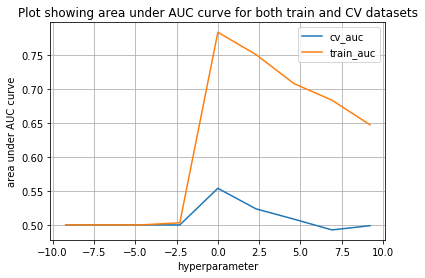

In [164]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

#### Observation:
<pre>From above plot we can see that as log(C) increases the area under ROC curve for training dataset increases exponentially where as the area under roc curve for cross validation dataset remians approximately around 50 to 55% thus indicating that our model is a overfitted model.</pre>

In [167]:
#From above we found the best value of C = 1. Therefor we will now test our model on our test dataset.
rbf_svm = SVC(C=1)
rbf_svm.fit(standardized_train,y_train_1)
pred = rbf_svm.predict(standardized_test)
print('For C = {0}, the area under AUC curve is = {1}'.format(1,roc_auc_score(y_test_1, pred)))

For C = 1, the area under AUC curve is = 0.5511921273363715


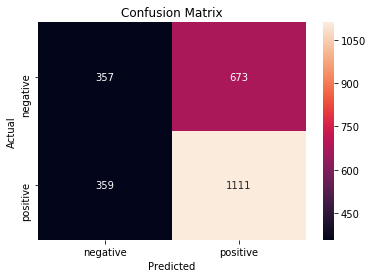

_____________________________________________________________________________________________________

For C = 1, the TPR = 75.578231292517, TNR = 34.66019417475728, FPR = 65.33980582524272, FNR = 24.421768707482993


In [168]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test_1,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(1,TPR,TNR,FPR,FNR))

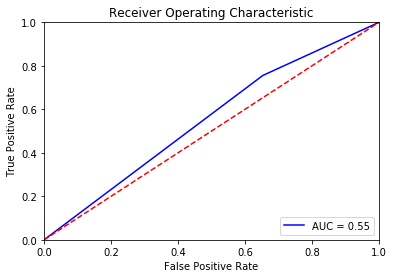

In [169]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test_1, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:
<pre>From above plot we can see that the area under roc curve is slightly greater than 50% and hence our model is slightly better than simple mean model.</pre>

# Conclusion

In [3]:
list_1 = [
         ['BOW','Linear SVM','L2',0.1,'NA',0.86],
         ['BOW','RBF SVM','NA','NA',0.1,0.5],
         ['TFIDF','Linear SVM','L2',1,'NA',0.85],
         ['TFIDF','RBF SVM','NA','NA',10,0.5],
         ['Average W2V','Linear SVM','L2',0.001,'NA',0.83],
         ['Average W2V','RBF SVM','NA','NA',1,0.80],
         ['Weighted W2V','Linear SVM','L2',0.01,'NA',0.57],
         ['Weighted W2V','RBF SVM','NA','NA',1,0.55]
         ]
columns= ['Vectorizer','Model','Regualrizer', 'alpha','C','AUC' ]
pd.DataFrame(list_1,columns = columns)

,Vectorizer,Model,Regualrizer,alpha,C,AUC
0,BOW,Linear SVM,L2,0.1,NA,0.86
1,BOW,RBF SVM,NA,NA,0.1,0.50
2,TFIDF,Linear SVM,L2,1,NA,0.85
3,TFIDF,RBF SVM,NA,NA,10,0.50
4,Average W2V,Linear SVM,L2,0.001,NA,0.83
5,Average W2V,RBF SVM,NA,NA,1,0.80
6,Weighted W2V,Linear SVM,L2,0.01,NA,0.57
7,Weighted W2V,RBF SVM,NA,NA,1,0.55


<pre>From above table we can see that RBF SVM performs worst than linear SVM. The RBF SVM is behaving mostly like a simple mean model. Linear SVM is performing better than RBF SVM when used with any of the vectorizers.  Bag Of Words with linear SVM is performing exceptionally better than all the other models. We also see that only L2 regularizer in Linear SVM is giving us better results. </pre>